In [1]:
import numpy as np
import random

from tile import Tile
from board import TileArray
from bases import BASES, BASE_FEATURES

In [2]:
%matplotlib inline

In [116]:
def generate_base(y, board):
    dist = abs((y - board.equator) / board.equator)
    dist = random.normalvariate(dist, 0.05)
    if dist < 0.1:
        base = 'grassland'
    elif 0.1 <= dist < 0.3:
        base = 'plains'
    elif 0.3 <= dist < 0.5:
        base = 'desert'
    elif 0.5 <= dist < 0.7:
        base = 'plains'
    else:
        base = 'tundra'
    return base

In [125]:
max_iter = 10000
max_num_continents = 5
max_num_islands = 20
min_continent_size = 100
max_continent_size = 400
min_island_size = 1
continent_shape = 0.3  # higher -> more stretchy

mountain_coverage = 0.2
mountain_shape = 1

hill_coverage = 0.5
mountain_shape = 0

forest_coverage = 0.4
forest_shape = 0.3  # higher -> more stretchy

rainforest_coverage = 0.3
rainforest_shape = 0  # higher -> more stretchy

snow_coverage = 0.4
snow_shape = 0

max_coast_width = 10
prob_coast = 0.05  # higher -> more coastal tiles

In [126]:
shape = (60, 60)
board = TileArray(shape=shape)
board.fill('ocean')

continents = []
islands = []
while len(continents) < max_num_continents and len(islands) < max_num_islands:
    # Main continent
    max_land_tiles = random.randint(min_island_size, max_continent_size)
    land_tiles = []
    i = 0
    while i < max_iter and not land_tiles:
        x_0, y_0 = (
            random.choice(range(shape[0])),
            random.choice(range(shape[1]))
        )
        if board[x_0, y_0].base == 'ocean' and 'coast' not in board[x_0, y_0].features:
            base = generate_base(y_0, board)
            land_tiles.append(Tile(x_0, y_0, base))
            board.set_tile(land_tiles[-1])
        else:
            i += 1
    if not land_tiles:
        break
    i = 0
    while len(land_tiles) < max_land_tiles and i < max_iter:
        if random.random() < continent_shape:
            old = land_tiles[-1]
        else:
            old = random.choice(land_tiles)
        ocean_tiles = board.search_neighbors(old, include_bases=['ocean'], exclude_features=['coast'])
        if ocean_tiles:
            new_x, new_y = random.choice(ocean_tiles)
            base = generate_base(new_y, board)
            new = Tile(new_x, new_y, base)
            land_tiles.append(new)
            board.set_tile(new)
        i += 1

    # Coastline
    coast_tiles = []
    for land_tile in land_tiles:
        ocean_tiles = board.search_neighbors(land_tile, include_bases=['ocean'], exclude_features=['coast'])
        if ocean_tiles:
            for new_x, new_y in ocean_tiles:
                new = Tile(new_x, new_y, 'ocean', features=['coast'])
                coast_tiles.append(new)
                board.set_tile(new)

    # Coast extension
    for _ in range(max_coast_width):
        new_coast_tiles = []
        for coast_tile in coast_tiles:
            ocean_tiles = board.search_neighbors(coast_tile, include_bases=['ocean'], exclude_features=['coast'])
            if ocean_tiles:
                for new_x, new_y in ocean_tiles:
                    if random.random() < prob_coast:
                        new = Tile(new_x, new_y, 'ocean', features=['coast'])
                        new_coast_tiles.append(new)
                        board.set_tile(new)
        coast_tiles += new_coast_tiles

    # Append to continents
    landmass = TileArray(shape=shape)
    for land_tile in land_tiles:
        landmass.set_tile(land_tile)
    if len(land_tiles) > min_continent_size:
        continents.append(landmass)
    else:
        islands.append(landmass)

In [127]:
# Mountains
max_mountain_tiles = mountain_coverage * board.n_land_tiles
mountain_tiles = []
i = 0
while len(mountain_tiles) < max_mountain_tiles and i < max_iter:
    mountain_range_tiles = []
    new_x, new_y = (
            random.choice(range(shape[0])),
            random.choice(range(shape[1]))
        )
    random_tile = board[new_x, new_y]
    exclude_bases = ['ocean', 'grassland']
    exclude_features = ['forest', 'ice', 'rainforest']
    if (random_tile.base not in exclude_bases and
            all(x not in random_tile.features for x in exclude_features)):
        random_tile.add_feature('mountain')
        mountain_range_tiles.append(random_tile)
        max_mountain_range_size = random.randint(1, 20)
        j = 0
        while len(mountain_range_tiles) < max_mountain_range_size and j < max_iter:
            if random.random() < mountain_shape:
                old = mountain_range_tiles[-1]
            else:
                old = random.choice(mountain_range_tiles)
            land_neighbors = board.search_neighbors(old, exclude_bases=['ocean', 'desert'])
            if land_neighbors:
                new_x, new_y = random.choice(land_neighbors)
                board[new_x, new_y].add_feature('mountain')
                mountain_range_tiles.append(board[new_x, new_y])
            j += 1
        mountain_tiles += mountain_range_tiles
    else:
        pass
    i += 1

# Hills
exclude_bases = ['ocean', 'lake']
max_hill_tiles = hill_coverage * board.n_land_tiles
hill_tiles = []
while len(hill_tiles) < int(0.1 * max_hill_tiles):
    new_x, new_y = (
            random.choice(range(shape[0])),
            random.choice(range(shape[1]))
        )
    random_tile = board[new_x, new_y]
    if random_tile.base not in exclude_bases and 'mountain' not in random_tile.features:
        random_tile.add_feature('hill')
        hill_tiles.append(random_tile)
while len(hill_tiles) < max_hill_tiles:
    if random.random() < forest_shape:
        old = hill_tiles[-1]
    else:
        old = random.choice(hill_tiles)
    land_neighbors = board.search_neighbors(old, exclude_bases=exclude_bases)
    if land_neighbors:
        new_x, new_y = random.choice(land_neighbors)
        board[new_x, new_y].add_feature('hill')
        hill_tiles.append(board[new_x, new_y])

# Forests
exclude_bases = ['ocean', 'desert']
max_forest_tiles = forest_coverage * board.n_land_tiles
forest_tiles = []
while len(forest_tiles) < int(0.1 * max_forest_tiles):
    new_x, new_y = (
            random.choice(range(shape[0])),
            random.choice(range(shape[1]))
        )
    random_tile = board[new_x, new_y]
    exclude_features = ['mountain', 'ice', 'forest', 'rainforest']
    if (random_tile.base not in exclude_bases and
            all(x not in random_tile.features for x in exclude_features)):
        random_tile.add_feature('forest')
        forest_tiles.append(random_tile)
while len(forest_tiles) < max_forest_tiles:
    if random.random() < forest_shape:
        old = forest_tiles[-1]
    else:
        old = random.choice(forest_tiles)
    land_neighbors = board.search_neighbors(old, exclude_bases=exclude_bases)
    if land_neighbors:
        new_x, new_y = random.choice(land_neighbors)
        board[new_x, new_y].add_feature('forest')
        forest_tiles.append(board[new_x, new_y])

# Rainforests
exclude_bases = ['ocean', 'desert', 'tundra']
max_rainforest_tiles = rainforest_coverage * board.n_land_tiles
rainforest_tiles = []
while len(rainforest_tiles) < int(0.1 * max_rainforest_tiles):
    new_x, new_y = (
            random.choice(range(shape[0])),
            random.choice(range(shape[1]))
        )
    random_tile = board[new_x, new_y]
    exclude_features = ['mountain', 'ice', 'snow', 'forest', 'rainforest']
    if (random_tile.base not in exclude_bases and
            all(x not in random_tile.features for x in exclude_features)):
        random_tile.add_feature('rainforest')
        rainforest_tiles.append(random_tile)
while len(rainforest_tiles) < max_rainforest_tiles:
    if random.random() < rainforest_shape:
        old = rainforest_tiles[-1]
    else:
        old = random.choice(rainforest_tiles)
    land_neighbors = board.search_neighbors(old, exclude_bases=exclude_bases)
    if land_neighbors:
        new_x, new_y = random.choice(land_neighbors)
        board[new_x, new_y].add_feature('rainforest')
        rainforest_tiles.append(board[new_x, new_y])

# Snow
include_bases = ['tundra']
max_snow_tiles = snow_coverage * board.n_land_tiles
snow_tiles = []
while len(snow_tiles) < int(0.1 * max_snow_tiles):
    new_x, new_y = (
            random.choice(range(shape[0])),
            random.choice(range(shape[1]))
        )
    random_tile = board[new_x, new_y]
    exclude_features = ['ice', 'snow', 'rainforest']
    if (random_tile.base in include_bases and
            all(x not in random_tile.features for x in exclude_features)):
        random_tile.add_feature('snow')
        snow_tiles.append(random_tile)
while len(snow_tiles) < max_rainforest_tiles:
    if random.random() < rainforest_shape:
        old = snow_tiles[-1]
    else:
        old = random.choice(snow_tiles)
    land_neighbors = board.search_neighbors(old, include_bases=include_bases)
    if land_neighbors:
        new_x, new_y = random.choice(land_neighbors)
        board[new_x, new_y].add_feature('snow')
        snow_tiles.append(board[new_x, new_y])

# Ice
ice_tiles = []
for tile in board:
    if tile.y == 0 or tile.y == board.shape[1] - 1:
        tile.add_feature('ice')
        ice_tiles.append(tile)
# Ice sheet extension
for _ in range(max_coast_width):
    new_ice_tiles = []
    for ice_tile in ice_tiles:
        neighbors = board.search_neighbors(ice_tile, exclude_features='ice')
        if neighbors:
            for new_x, new_y in neighbors:
                if random.random() < prob_coast:
                    board[new_x, new_y].add_feature('ice')
                    new_ice_tiles.append(board[new_x, new_y])
    ice_tiles += new_ice_tiles

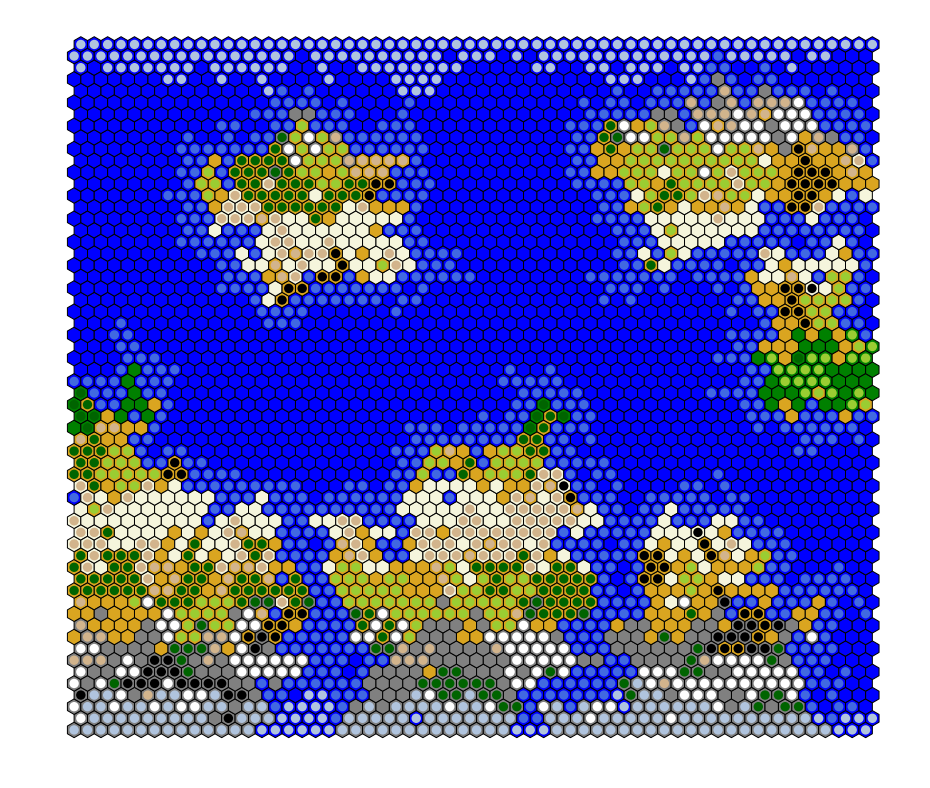

In [128]:
board.show(fig_scale=2)